In [1]:
### General
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, vstack, join, unique
from astroquery.gaia import Gaia
from astroquery.sdss import SDSS

### Tools
import sys
sys.path.append('../')
import wdphoto
from wdphoto import LaPlataBase, LaPlataUltramassive, WarwickDAInterpolator, CoarseEngine, MCMCEngine, deredden

sys.path.append('../../../proj/')
import WD_models

from astroquery.vizier import Vizier

plt.style.use('stefan.mplstyle')

In [2]:
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16
speed_light = 299792458 #m/s

def one_model(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f', atm_type = 'H'):
    ONe_model = WD_models.load_model('ft', 'ft', 'o', atm_type = atm_type, HR_bands = ['bp3-rp3', 'G3'])
    g_acc = (10**ONe_model['logg'])/100
    rsun = np.sqrt(ONe_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    x_m, y_m, z_m, rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**ONe_model['logteff'],\
                                                z = ONe_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

def co_model(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f', atm_type = 'H'):
    CO_model = WD_models.load_model('ft', 'ft', 'ft', atm_type = atm_type, HR_bands = ['bp3-rp3', 'G3'])
    g_acc = (10**CO_model['logg'])/100
    rsun = np.sqrt(CO_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    x_m, y_m, z_m, rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**CO_model['logteff'],\
                                                z = CO_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

In [3]:
bands = ['Gaia_RP', 'Gaia_BP']#, 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']

one_hrich = LaPlataUltramassive(bands, core = 'ONe', layer = 'Hrich')
one_hdef = LaPlataUltramassive(bands, core = 'ONe', layer = 'Hdef')

co_hrich = LaPlataUltramassive(bands, core = 'CO', layer = 'Hrich')
co_hdef = LaPlataUltramassive(bands, core = 'CO', layer = 'Hdef')

rad_array = np.linspace(0.0045, 0.007, 100)

In [4]:
teffarray = 16237

ONe_model = WD_models.load_model('ft', 'ft', 'o', atm_type = 'H', HR_bands = ['bp3-rp3', 'G3'])

print('Teff inputs are the same:', np.all(np.isclose(one_hrich.teff_array, 10**ONe_model['logteff'][-one_hrich.mass_array.shape[0]:])))
print('logg inputs are the same:', np.all(np.isclose(one_hrich.logg_array, ONe_model['logg'][-one_hrich.mass_array.shape[0]:])))
print('mass inputs are the same:', np.all(np.isclose(one_hrich.mass_array, ONe_model['mass_array'][-one_hrich.mass_array.shape[0]:])))

g_acc_model = (10**one_hrich.logg_array)/100
g_acc_sihao = (10**ONe_model['logg'][-one_hrich.mass_array.shape[0]:])/100

print('transformed logg inputs are the same:', np.all(np.isclose(g_acc_model, g_acc_sihao)))

rsun_model = np.sqrt(one_hrich.mass_array * mass_sun * newton_G / g_acc_model) / radius_sun
rsun_sihao = np.sqrt(ONe_model['mass_array'][-one_hrich.mass_array.shape[0]:] * mass_sun * newton_G / g_acc_sihao) / radius_sun

print('radius inputs are the same:', np.all(np.isclose(rsun_model, rsun_sihao)))

x_m, y_m, z_m, rsun_teff_to_m_model =  WD_models.interp_xy_z_func(x = rsun_model, y = one_hrich.teff_array, z = one_hrich.mass_array, interp_type = 'linear')
x_s, y_s, z_s, rsun_teff_to_m_sihao = WD_models.interp_xy_z_func(x = rsun_sihao, y = 10**ONe_model['logteff'][-one_hrich.mass_array.shape[0]:], 
                                                  z = ONe_model['mass_array'][-one_hrich.mass_array.shape[0]:], interp_type = 'linear')

mass_model = rsun_teff_to_m_model(rad_array, teffarray) * mass_sun
mass_sihao = rsun_teff_to_m_sihao(rad_array, teffarray) * mass_sun

print('interpolator inputs are the same:', np.all([np.isclose(x_m, x_s), np.isclose(y_m, y_s), np.isclose(z_m, z_s)]))
print('mass outputs are the same:', np.all(np.isclose(mass_model, mass_sihao)))

gravz_model = newton_G * mass_model / (speed_light * rad_array * radius_sun)
gravz_sihao = newton_G * mass_sihao / (speed_light * rad_array * radius_sun)

print('gravz outputs are the same:', np.all(np.isclose(gravz_model, gravz_sihao)))

Teff inputs are the same: True
logg inputs are the same: True
mass inputs are the same: True
transformed logg inputs are the same: True
radius inputs are the same: True
interpolator inputs are the same: True
mass outputs are the same: False
gravz outputs are the same: False


In [5]:
vg_array_one_hrich = newton_G * one_hrich.radiustomass(rad_array, 16278) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3
vg_array_one_hdef = newton_G * one_hdef.radiustomass(rad_array, 16278) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3

vg_array_co_hrich =  newton_G * co_hrich.radiustomass(rad_array, 16278) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3
vg_array_co_hdef =  newton_G * co_hdef.radiustomass(rad_array, 16278) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3

vg_array_one_H = one_model(rad_array, 16278, atm_type = 'H')
vg_array_one_He = one_model(rad_array, 16278, atm_type = 'He')
vg_array_co_H = co_model(rad_array, 16278, atm_type = 'H')

Text(0, 0.5, '$\\Delta v_g$ [$kms^{-1}$]')

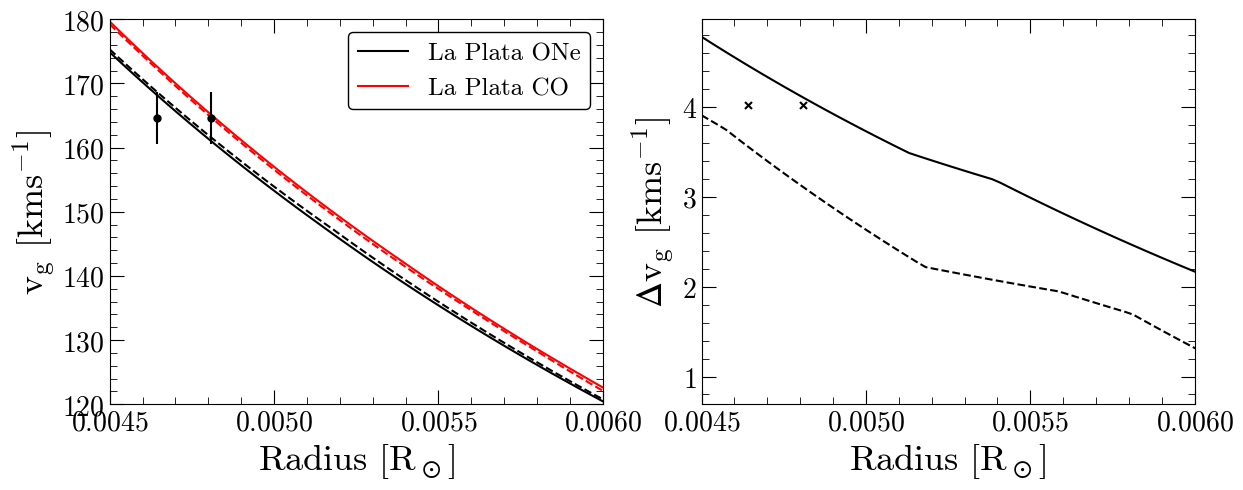

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(14, 5))

gravz = [164.57803000880688]
e_gravz = [4.028643226861689]
radius_co = [0.004808784290090289]
radius_one = [0.004642770041853178]

#ax1.plot(rad_array, vg_array_one_H, label='Sihao ONe')
ax1.plot(rad_array, vg_array_one_hrich, c = 'k', label='La Plata ONe')
ax1.plot(rad_array, vg_array_one_hdef, c = 'k', ls = '--')

#ax1.plot(rad_array, vg_array_co_H, c = 'r', label='Fontaine CO')
ax1.plot(rad_array, vg_array_co_hrich, c = 'r', label = 'La Plata CO')
ax1.plot(rad_array, vg_array_co_hdef, c = 'r', ls = '--')

ax1.errorbar(radius_one, gravz, yerr = e_gravz, fmt='o', c = 'k', zorder=100)
ax1.errorbar(radius_co, gravz, yerr = e_gravz, fmt='o', c = 'k', zorder=100)


ax1.set_xlim(0.0045, 0.006)
ax1.set_ylim(120, 180)

ax1.set_xlabel(r'Radius [$R_\odot$]')
ax1.set_ylabel(r'$v_g$ [$kms^{-1}$]')
ax1.legend()

ax2.plot(rad_array, vg_array_co_hrich - vg_array_one_hrich, c = 'k')
ax2.plot(rad_array, vg_array_co_hdef - vg_array_one_hdef, c = 'k', ls = '--')
#ax2.plot(rad_array, vg_array_co_hrich - vg_array_one_H, c = 'k', label = 'La Plata CO - La Plata ONe')
#ax2.plot(rad_array, vg_array_co_hdef - vg_array_one_He, c = 'k', ls = '--')

#ax2.plot(rad_array, vg_array_co_H - vg_array_one_H, c='r', label='Fontaine CO - La Plata ONe')

ax2.scatter(radius_one, e_gravz, c = 'k', marker = 'x', s = 25)
ax2.scatter(radius_co, e_gravz, c = 'k', marker = 'x', s = 25)


ax2.set_xlim(0.0045, 0.006)

ax2.set_xlabel(r'Radius [$R_\odot$]')
ax2.set_ylabel(r'$\Delta v_g$ [$kms^{-1}$]')


In [7]:
base_model_Hrich = wdphoto.LaPlataBase(bands, layer = 'Hrich')
base_model_Hdef = wdphoto.LaPlataBase(bands, layer = 'Hdef')

masses = np.linspace(0.2, 1.0, 100)
teff = np.linspace(5000, 75000, 5)

masses_arr = [masses for t in teff]

thin_radii = np.array([base_model_Hdef.massradius(masses, temp) for temp in teff])
thick_radii = np.array([base_model_Hrich.massradius(masses, temp) for temp in teff])

Text(0, 0.5, 'Radius $[R_\\odot]$')

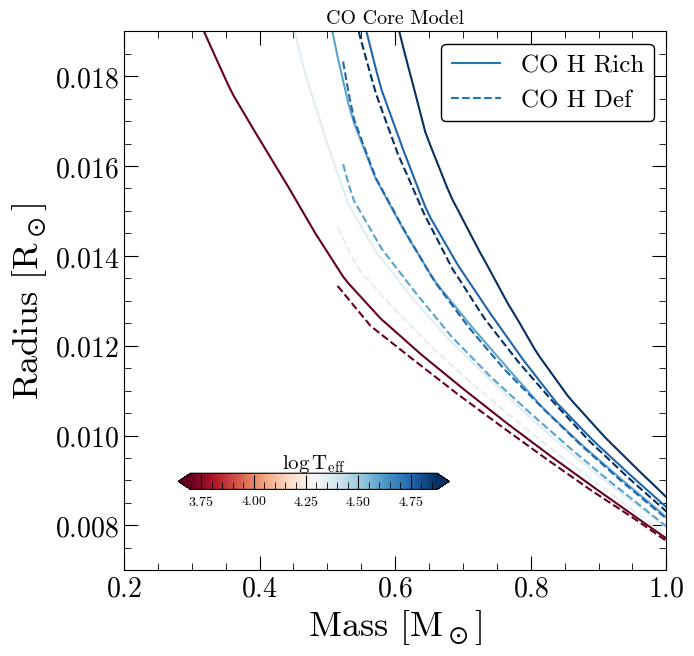

In [8]:
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(ncols=1, figsize=(7, 7))

co_hdef_stack = [np.column_stack([x,y]) for x, y in zip(masses_arr, thin_radii)]
co_hrich_stack = [np.column_stack([x,y]) for x, y in zip(masses_arr, thick_radii)]

ax.set_xlim(0.2, 1)
ax.set_ylim(0.007, 0.019)
ax.set_title('CO Core Model')

line_collection = LineCollection(co_hrich_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='CO H Rich')
ax.add_collection(line_collection)
line_collection = LineCollection(co_hdef_stack, array=np.log10(teff), cmap='RdBu', ls = '--', label='CO H Def')
ax.add_collection(line_collection)

cbaxes = ax.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(line_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax.legend()
ax.set_xlabel(r'Mass $[M_\odot]$')
ax.set_ylabel(r'Radius $[R_\odot]$')

In [9]:
# https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/A%2bA/658/A22/table5
catalog = Table.read('raddi.csv')

In [10]:
print(len(catalog))

2119


In [12]:
bands = ['Gaia_RP', 'Gaia_BP']#, 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']

warwick = WarwickDAInterpolator(bands)
baseline = LaPlataBase(bands, layer='Hrich')
co_hrich = LaPlataUltramassive(bands, core = 'CO', layer = 'Hrich')
co_hdef = LaPlataUltramassive(bands, core = 'CO', layer = 'Hdef')
one_hrich = LaPlataUltramassive(bands, core = 'ONe', layer =  'Hrich')
one_hdef = LaPlataUltramassive(bands, core = 'ONe', layer = 'Hdef')

WarwickEngine = CoarseEngine(warwick)
BaselineEngine = CoarseEngine(baseline)
CO_HrichEngine = CoarseEngine(co_hrich)
CO_HdefEngine = CoarseEngine(co_hdef)
ONe_HrichEngine = CoarseEngine(one_hrich)
ONe_HdefEngine = CoarseEngine(one_hdef)

In [13]:
for i in range(len(catalog)):
    catalog['Radius'][i] = baseline.radius_interp(catalog['teff'][i], catalog['logg'][i])

AttributeError: 'LaPlataBase' object has no attribute 'radius_interp'

In [14]:
catalog = catalog[~np.isnan(catalog['Radius'])]
obs_mag = np.array(catalog[['phot_rp_mean_mag', 'phot_bp_mean_mag']])#, 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z']])
e_obs_mag = np.array(catalog[['e_rpmag', 'e_bpmag']])#, 'psfMagErr_u', 'psfMagErr_g', 'psfMagErr_r', 'psfMagErr_i', 'psfMagErr_z']])
distances = np.array(catalog['r_med_geo'])

In [15]:
i = 2
print(catalog[['Radius', 'teff', 'logg']][i])
print(BaselineEngine(obs_mag[i], e_obs_mag[i], distances[i]))

Radius    teff   logg
------ --------- ----
 0.013 12331.048 7.93
(0.014415743757646593, 9.271089741001669e-07, 11888.0535339551, 0.6239681613852617, 8.25, 0, <lmfit.minimizer.MinimizerResult object at 0x7f7c3bf58f20>)


In [28]:
outs = np.nan*np.zeros((6, len(obs_mag), 6))

for i in tqdm(range(len(obs_mag))):
    outs[0,i] = BaselineEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 8, 0.003])[:6]#, p0=[catalog['teff'][i], catalog['logg'][i], 0.003])
    outs[1,i] = CO_HrichEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 9, 0.003])[:6]
    outs[2,i] = CO_HdefEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 9, 0.003])[:6]
    outs[3,i] = ONe_HrichEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 9, 0.003])[:6]
    outs[4,i] = ONe_HdefEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 9, 0.003])[:6]
    outs[5,i] = WarwickEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 8, 0.003])[:6]

  0%|          | 0/2119 [00:00<?, ?it/s]

100%|██████████| 2119/2119 [14:22<00:00,  2.46it/s]


In [29]:
catalog.rename_column('Radius', 'Raddi_radius')

catalog['Baseline_radius'] = outs[0,:,0]
catalog['Baseline_e_radius'] = outs[0,:,1]
catalog['Baseline_teff'] = outs[0,:,2]
catalog['Baseline_e_teff'] = outs[0,:,3]
catalog['Baseline_chi2'] = outs[0,:,-1]
catalog['Baseline_roe'] = catalog['Baseline_radius'] / catalog['Baseline_e_radius']

catalog['CO_Hrich_radius'] = outs[1,:,0]
catalog['CO_Hrich_e_radius'] = outs[1,:,1]
catalog['CO_Hrich_teff'] = outs[1,:,2]
catalog['CO_Hrich_e_teff'] = outs[1,:,3]
catalog['CO_Hrich_chi2'] = outs[1,:,-1]
catalog['CO_Hrich_roe'] = catalog['CO_Hrich_radius']/catalog['CO_Hrich_e_radius']

catalog['CO_Hdef_radius'] = outs[2,:,0]
catalog['CO_Hdef_e_radius'] = outs[2,:,1]
catalog['CO_Hdef_teff'] = outs[2,:,2]
catalog['CO_Hdef_e_teff'] = outs[2,:,3]
catalog['CO_Hdef_chi2'] = outs[2,:,-1]
catalog['CO_Hdef_roe'] = catalog['CO_Hdef_radius']/catalog['CO_Hdef_e_radius']

catalog['ONe_Hrich_radius'] = outs[3,:,0]
catalog['ONe_Hrich_e_radius'] = outs[3,:,1]
catalog['ONe_Hrich_teff'] = outs[3,:,2]
catalog['ONe_Hrich_e_teff'] = outs[3,:,3]
catalog['ONe_Hrich_chi2'] = outs[3,:,-1]
catalog['ONe_Hrich_roe'] = catalog['ONe_Hrich_radius']/catalog['ONe_Hrich_e_radius']

catalog['ONe_Hdef_radius'] = outs[4,:,0]
catalog['ONe_Hdef_e_radius'] = outs[4,:,1]
catalog['ONe_Hdef_teff'] = outs[4,:,2]
catalog['ONe_Hdef_e_teff'] = outs[4,:,3]
catalog['ONe_Hdef_chi2'] = outs[4,:,-1]
catalog['ONe_Hdef_roe'] = catalog['ONe_Hdef_radius']/catalog['ONe_Hdef_e_radius']

catalog['Warwick_radius'] = outs[5,:,0]
catalog['Warwick_e_radius'] = outs[5,:,1]
catalog['Warwick_teff'] = outs[5,:,2]
catalog['Warwick_e_teff'] = outs[5,:,3]
catalog['Warwick_chi2'] = outs[5,:,-1]
catalog['Warwick_roe'] = catalog['Warwick_radius']/catalog['Warwick_e_radius']

KeyError: 'Column Radius does not exist'

In [ ]:
Baseline_failed = np.any([catalog['Baseline_chi2'] > 5, catalog['Baseline_roe'] < 5], axis=0)
CO_Hrich_failed = np.any([catalog['CO_Hrich_chi2'] > 5, catalog['CO_Hrich_roe'] < 5], axis=0)
CO_Hdef_failed = np.any([catalog['CO_Hdef_chi2'] > 5, catalog['CO_Hdef_roe'] < 5], axis=0)
ONe_Hrich_failed = np.any([catalog['ONe_Hrich_chi2'] > 5, catalog['ONe_Hrich_roe'] < 5], axis=0)
ONe_Hdef_failed = np.any([catalog['ONe_Hdef_chi2'] > 5, catalog['ONe_Hdef_roe'] < 5], axis=0)
Warwick_failed = np.any([catalog['Warwick_chi2'] > 5, catalog['Warwick_roe'] < 5], axis=0)

In [ ]:
print(f'Baseline_failed={len(catalog[Baseline_failed])/len(catalog)*100:2.2f}%')
print(f'CO_Hrich_failed={len(catalog[CO_Hrich_failed])/len(catalog)*100:2.2f}%')
print(f'CO_Hdef_failed={len(catalog[CO_Hdef_failed])/len(catalog)*100:2.2f}%')
print(f'ONe_Hrich_failed={len(catalog[ONe_Hrich_failed])/len(catalog)*100:2.2f}%')
print(f'ONe_Hdef_failed={len(catalog[ONe_Hdef_failed])/len(catalog)*100:2.2f}%')
print(f'Warwick_failed={len(catalog[Warwick_failed])/len(catalog)*100:2.2f}%')


mask = np.all([~Baseline_failed, ~CO_Hrich_failed, ~CO_Hdef_failed,
               ~ONe_Hrich_failed, ~ONe_Hdef_failed, ~Warwick_failed], axis=0)
print(f'\nTotal failed={(1-len(catalog[mask])/len(catalog))*100:2.2f}%')

Baseline_failed=0.00%
CO_Hrich_failed=0.00%
CO_Hdef_failed=0.00%
ONe_Hrich_failed=0.00%
ONe_Hdef_failed=0.00%
Warwick_failed=0.00%

Total failed=0.00%


/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Report: 
      mean ONe Hdef=nan Rsun / mean ONe Hrich=nan Rsun
      mean CO Hdef=nan Rsun / mean CO Hrich=nan Rsun


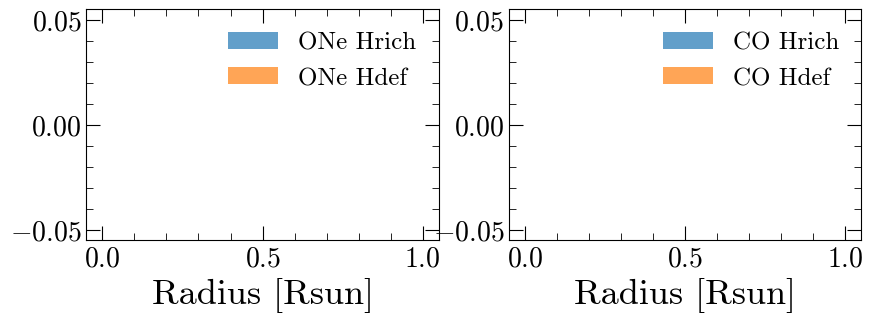

In [ ]:
himask = np.all([mask, catalog['ONe_Hrich_radius'] < 1], axis=0)

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.hist(catalog['ONe_Hrich_radius'][himask], alpha=0.7, label='ONe Hrich')#, bins=15)
plt.hist(catalog['ONe_Hdef_radius'][himask], alpha=0.7, label='ONe Hdef')#, bins=15)
plt.xlabel('Radius [Rsun]')
plt.legend(framealpha=0)

plt.subplot(122)
plt.hist(catalog['CO_Hrich_radius'][himask], alpha=0.7, label='CO Hrich')#, bins=15)
plt.hist(catalog['CO_Hdef_radius'][himask], alpha=0.7, label='CO Hdef')#, bins=15)
plt.xlabel('Radius [Rsun]')

plt.legend(framealpha=0)

print(f"""Report: 
      mean ONe Hdef={np.mean(catalog['ONe_Hdef_radius'][himask]):2.4f} Rsun / mean ONe Hrich={np.mean(catalog['ONe_Hrich_radius'][himask]):2.4f} Rsun
      mean CO Hdef={np.mean(catalog['CO_Hdef_radius'][himask]):2.4f} Rsun / mean CO Hrich={np.mean(catalog['CO_Hrich_radius'][himask]):2.4f} Rsun""")

Text(0, 0.5, 'Warwick Radius')

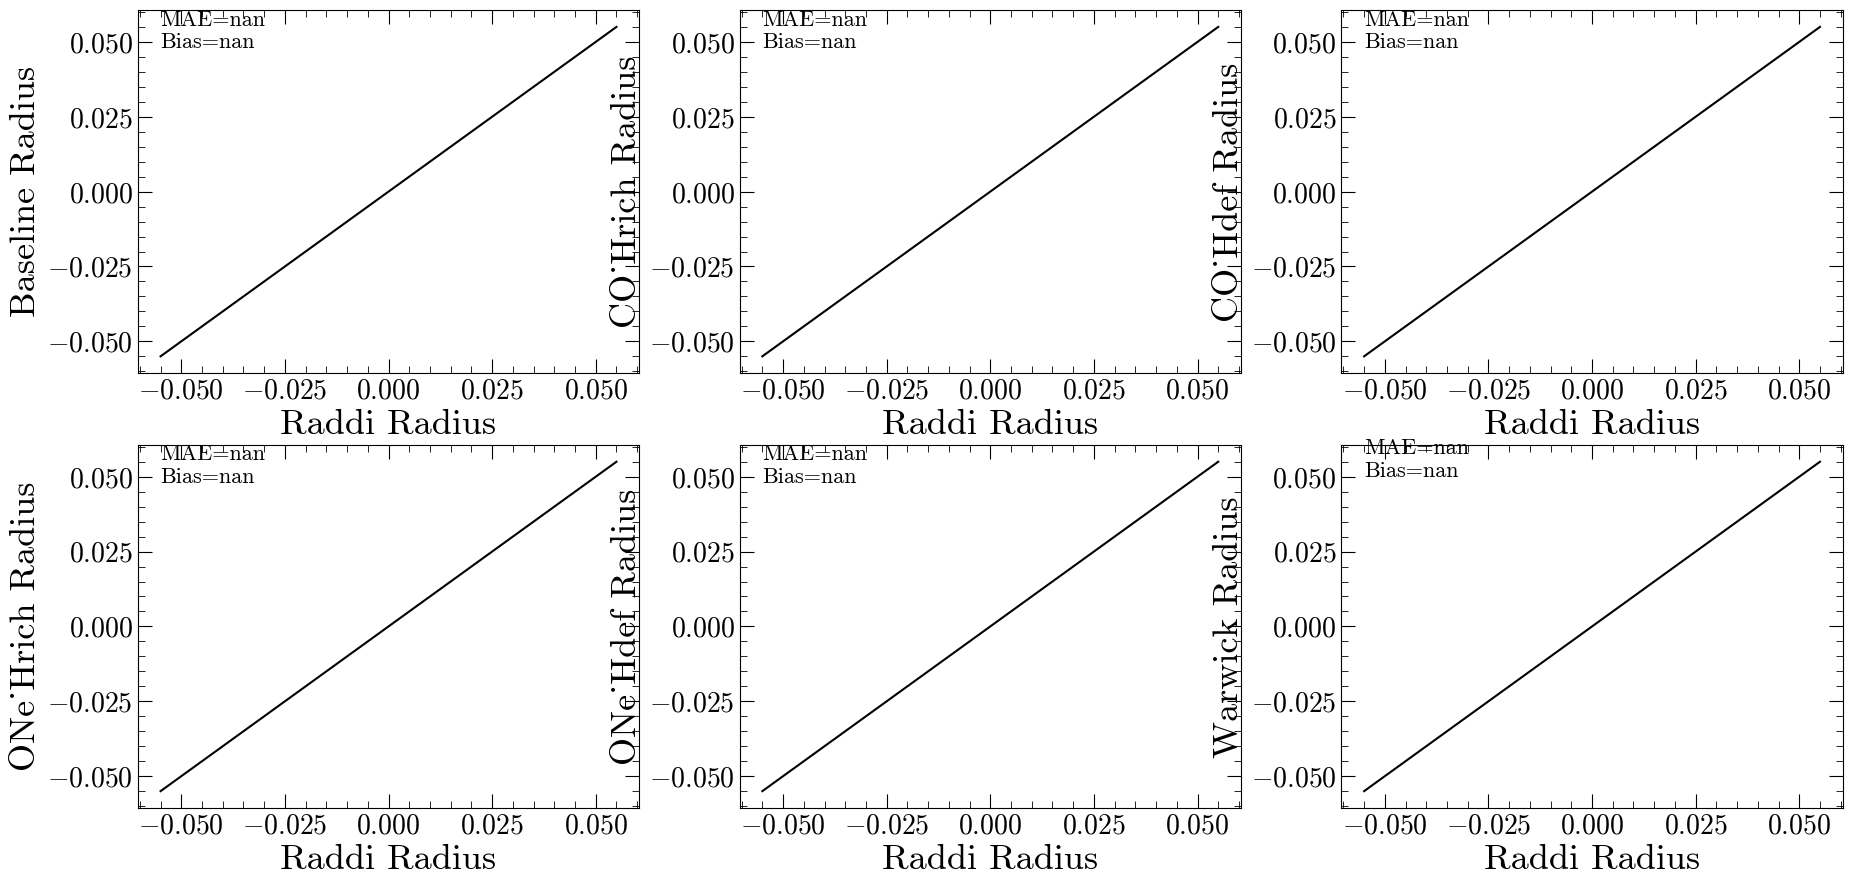

In [ ]:
plt.figure(figsize=(22,16))

plt.subplot(331)
mae = np.sum(np.abs(catalog[mask]['Raddi_radius'] - catalog[mask]['Baseline_radius'])) / len(catalog[mask])
bias = np.average(catalog[mask]['Raddi_radius'] - catalog[mask]['Baseline_radius'])
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['Baseline_radius'], yerr=catalog[mask]['Baseline_e_radius'], fmt='o')
xlims = plt.xlim()
ylims = plt.ylim()
plt.text(xlims[0], ylims[1]-0.007, f'MAE={mae:2.4f}\nBias={bias:2.4f}', fontsize=16)
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('Baseline Radius')

plt.subplot(332)
mae = np.sum(np.abs(catalog[mask]['Raddi_radius'] - catalog[mask]['CO_Hrich_radius'])) / len(catalog[mask])
bias = np.average(catalog[mask]['Raddi_radius'] - catalog[mask]['CO_Hrich_radius'])
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['CO_Hrich_radius'], yerr=catalog[mask]['CO_Hrich_e_radius'], fmt='o')
xlims = plt.xlim()
ylims = plt.ylim()
plt.text(xlims[0], ylims[1]-0.007, f'MAE={mae:2.4f}\nBias={bias:2.4f}', fontsize=16)
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('CO_Hrich Radius')

plt.subplot(333)
mae = np.sum(np.abs(catalog[mask]['Raddi_radius'] - catalog[mask]['CO_Hdef_radius'])) / len(catalog[mask])
bias = np.average(catalog[mask]['Raddi_radius'] - catalog[mask]['CO_Hdef_radius'])
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['CO_Hdef_radius'], yerr=catalog[mask]['CO_Hdef_e_radius'], fmt='o')
xlims = plt.xlim()
ylims = plt.ylim()
plt.text(xlims[0], ylims[1]-0.007, f'MAE={mae:2.4f}\nBias={bias:2.4f}', fontsize=16)
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('CO_Hdef Radius')

plt.subplot(334)
mae = np.sum(np.abs(catalog[mask]['Raddi_radius'] - catalog[mask]['ONe_Hrich_radius'])) / len(catalog[mask])
bias = np.average(catalog[mask]['Raddi_radius'] - catalog[mask]['ONe_Hrich_radius'])
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['ONe_Hrich_radius'], yerr=catalog[mask]['ONe_Hrich_e_radius'], fmt='o')
xlims = plt.xlim()
ylims = plt.ylim()
plt.text(xlims[0], ylims[1]-0.007, f'MAE={mae:2.4f}\nBias={bias:2.4f}', fontsize=16)
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('ONe_Hrich Radius')

plt.subplot(335)
mae = np.sum(np.abs(catalog[mask]['Raddi_radius'] - catalog[mask]['ONe_Hdef_radius'])) / len(catalog[mask])
bias = np.average(catalog[mask]['Raddi_radius'] - catalog[mask]['ONe_Hdef_radius'])
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['ONe_Hdef_radius'], yerr=catalog[mask]['ONe_Hdef_e_radius'], fmt='o')
xlims = plt.xlim()
ylims = plt.ylim()
plt.text(xlims[0], ylims[1]-0.007, f'MAE={mae:2.4f}\nBias={bias:2.4f}', fontsize=16)
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('ONe_Hdef Radius')

plt.subplot(336)
mae = np.sum(np.abs(catalog[mask]['Raddi_radius'] - catalog[mask]['Warwick_radius'])) / len(catalog[mask])
bias = np.average(catalog[mask]['Raddi_radius'] - catalog[mask]['Warwick_radius'])
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['Warwick_radius'], yerr=catalog[mask]['Warwick_e_radius'], fmt='o')
xlims = plt.xlim()
ylims = plt.ylim()
plt.text(xlims[0], ylims[1]-0.005, f'MAE={mae:2.4f}\nBias={bias:2.4f}', fontsize=16)
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('Warwick Radius')